In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import PIL.Image
from datetime import datetime
import PIL.ExifTags
from tqdm import tqdm

import dateutil.parser
import os
import re

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, MaxNLocator)

from pyphasechip import pyphasechip_logic as pypc
from typing import Tuple

## Variables

In [2]:
# reagent 1 name
name_sol1 = "BSA"
# reagent 1 starting contentration
initial_conc_sol1 = 266
# unit
unit_sol1 = "µM"


# reagent 2 name
name_sol2 = "PEG"
# reagent 2 starting concentration
initial_conc_sol2 = 10
# unit
unit_sol2 = "%"


# mixing ratio of the concentrations 0
# [1:X]
initial_ratio = 7


# Number of different concentrations used
number_of_diff_conc = 4

# Number of wells
n_wells = 3

###### delete hoe and iph, use this instead
# total amount of images
total_n_images = 528
n_timepoints = int(total_n_images / (number_of_diff_conc * n_wells)) 

# percental difference of img mean to all previous imgages. 
# value is similar to a sensivity-value
percental_threshold = 200 #55


# measured diameter of chamber to calculate radii for circle detection -> min and max [px]
# around +-30 of the real value, best measured with something like imageJ/Fiji
diameter = 238 
minRadiusChamber = int((diameter/2)*0.7)
maxRadiusChamber = int((diameter/2)*1.3)


# height of chamber [µm]
chamber_height = 60

# folder where images are stored
# best is to use only paths without any whitespace
image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\20220601_BSA_PEG_FC40_subset"
#image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\Testimages2+"

# datatype of the images
extension = ".jpg"

# TODO: use a .yml file for storing these variables

In [ ]:
#THIS IS FOR CELLOBSERVER/ZEISS IMAGES ONLY

def get_sorted_file_list(image_folder: str) -> list:
    files, times, concs, wells = [], [], [], []
    
    for file in os.listdir(image_folder):
        # 1. More robust, faster, but more specific
        c, w, _, t = re.search("c(\d+)_w(\d+)_s(\d+)t(\d+)", file).groups()

        # 2. Other way
        #c, w, _, t, *params = re.findall('[0-9]+', file)
        
        # Generate lists
        times.append(int(t))
        concs.append(int(c))
        wells.append(int(w))
        files.append(file)
        
    return [x for _, _, _, x in sorted(zip(concs, times, wells, files))]
    
get_sorted_file_list(image_folder)

## Programm

In [3]:
# Create all the necessary dicts and lists
image_list, image_names, data_well, well, concentration, time_resolution = pypc.create()

# Load images & convert to grayscale
print("Write images into list")
pypc.images_to_list(image_list, image_names, image_folder, extension)
print("Save them into a dictionary")
pypc.images_to_dict(n_timepoints, number_of_diff_conc, n_wells, image_list, image_names, time_resolution, concentration, well, data_well)

# Two possibilities:
# use script if you did a pipetting series
starting_concentrations = pypc.starting_concentration(initial_conc_sol1, initial_conc_sol2, initial_ratio)
# or
# write list

print("Analyse data...")
well_nr = 0
for conc_nr in range(number_of_diff_conc): # for n_rows_per_conc in range(2):
    
    for n_wells_per_row in range(n_wells):

        # Initialise variables, arrays and lists
        well_data = np.zeros(shape=(2, 3))
        threshed_img = np.zeros(shape=time_resolution[0][0][0]['gray'].shape, dtype="uint8")
        areas = np.zeros(shape=(1, 2))
        droplet_arr = np.zeros(shape=(2,4))
        mean_list = []
        llps_status = False
        n_0 = 0
        multiple_droplets = None
        multiple_droplets_count = 0

        print("conc:", conc_nr, "well:", well_nr)
        for time_idx in tqdm(range(n_timepoints)): #n_timepoints
            if llps_status is False:
                #print("---", "C:", conc_nr, "W:", well_nr, " T:", time_idx, "---")

                image = time_resolution[time_idx][conc_nr][well_nr]['gray'].copy()

                x, y, r, droplet_data, droplet_found, multiple_droplets_count, masked_img, grad2, well_data = pypc.droplet_detection(image, well_data, diameter, llps_status,
                                                                                                                                     multiple_droplets_count, droplet_arr, time_idx, conc_nr, well_nr)

                time_resolution[time_idx][conc_nr][well_nr]['img'] = masked_img
                time_resolution[time_idx][conc_nr][well_nr]['grad2'] = grad2
                time_resolution[time_idx][conc_nr][well_nr]['manipulated img'] = grad2 # needed for display
                time_resolution[time_idx][conc_nr][well_nr]['droplet data'] = droplet_arr.copy()
                time_resolution[time_idx][conc_nr][well_nr]['x'] = x # needed for display
                time_resolution[time_idx][conc_nr][well_nr]['y'] = y # needed for display
                time_resolution[time_idx][conc_nr][well_nr]['r'] = well_data[0, 2] # needed for display
                time_resolution[0][conc_nr][well_nr]['multiple droplets'] = multiple_droplets_count

                # save first area
                if time_idx == 0:
                    areas[0, 0] = droplet_arr[0, 3]

                llps_status, areas, mean_list, droplet_arr, squi, cro_squi, n_0 = pypc.detect_LLPS(percental_threshold, droplet_arr, llps_status, masked_img, time_idx, areas, mean_list, droplet_found, n_0)

                # if noise is too high, ignore droplet
                # later: change "multiplet droplets" to "ignore well"
                if n_0 > 400:
                    multiple_droplets = True
                    time_resolution[0][conc_nr][well_nr]['multiple droplets'] = multiple_droplets


                time_resolution[0][conc_nr][well_nr]['areas'] = areas
                time_resolution[0][conc_nr][well_nr]['mean list'] = mean_list
                time_resolution[time_idx][conc_nr][well_nr]['squ'] = squi
                time_resolution[time_idx][conc_nr][well_nr]['cro squ'] = cro_squi

                time_resolution[time_idx][conc_nr][well_nr]['droplet array'] = droplet_arr


                if llps_status is True:
                    print("LLPS status: ", llps_status, ", @", "c:", conc_nr, "w:", well_nr, "t:", time_idx)
                    # save img time where llps was found
                    time_resolution[0][conc_nr][well_nr]['time idx'] = time_idx
                    # save name of image where LLPS was detected
                    time_resolution[0][conc_nr][well_nr]['LLPS name'] = time_resolution[time_idx][conc_nr][well_nr]['name']
                    # calculate the critical concentration
                    llps_conc = pypc.ccrit_calculation(starting_concentrations, areas, conc_nr)
                    time_resolution[0][conc_nr][well_nr]['LLPS conc'] = llps_conc

        well_nr += 1
    well_nr = 0

# saves the image names where LLPS was detected and the calculated concentrations to a csv file
# .csv gets safed in the image folder
#pypc.save_results_to_csv(time_resolution, image_folder, number_of_diff_conc, n_wells, hours_of_experiment,
#                       images_per_hour, name_sol1, name_sol2, unit_sol1, unit_sol2)

Write images into list


100%|████████████████████████████████████████████████████████████████████████████████| 528/528 [00:05<00:00, 91.67it/s]


Save them into a dictionary


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

Analyse data...
conc: 0 well: 0
multiple_droplets: n = 66
status: 0,0,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 400,307,105
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:42,  1.01it/s]

multiple_droplets: n = 93
status: 0,0,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 400,306,102
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:41,  1.01it/s]

multiple_droplets: n = 26
status: 0,0,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 398,304,100
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:39,  1.04it/s]

multiple_droplets: n = 57
status: 0,0,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 405,306,99
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:38,  1.04it/s]

multiple_droplets: n = 138
status: 0,0,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,304,95
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:37,  1.04it/s]

multiple_droplets: n = 157
status: 0,0,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 408,303,93
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:36,  1.05it/s]

status: 0,0,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 407,312,95
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:33,  1.09it/s]

status: 0,0,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,310,91
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:32,  1.12it/s]

status: 0,0,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 405,309,84
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:08<00:30,  1.14it/s]

status: 0,0,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 393,302,79
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:09<00:29,  1.15it/s]

status: 0,0,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 390,310,73
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:10<00:29,  1.14it/s]

status: 0,0,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 401,309,107
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:27,  1.15it/s]

status: 0,0,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 398,302,75
status: droplet_found: True


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:26,  1.16it/s]

status: 0,0,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 398,286,65
status: droplet_found: True


 32%|██████████████████████████                                                        | 14/44 [00:12<00:25,  1.18it/s]

status: 0,0,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 335,244,110
status: droplet_found: True


 34%|███████████████████████████▉                                                      | 15/44 [00:13<00:24,  1.17it/s]

status: 0,0,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 398,285,58
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 0 t: 15
conc: 0 well: 1
multiple_droplets: n = 77
status: 0,1,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 374,282,94
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:41,  1.04it/s]

multiple_droplets: n = 276
status: 0,1,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 355,253,107
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:40,  1.03it/s]

multiple_droplets: n = 102
status: 0,1,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 372,276,87
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:38,  1.06it/s]

multiple_droplets: n = 355
status: 0,1,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 390,295,106
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:37,  1.07it/s]

multiple_droplets: n = 362
status: 0,1,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 380,292,109
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:37,  1.03it/s]

multiple_droplets: n = 361
status: 0,1,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 383,293,107
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:36,  1.03it/s]

status: 0,1,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 360,274,81
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:34,  1.09it/s]

status: 0,1,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 387,292,109
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:32,  1.12it/s]

status: 0,1,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 359,275,71
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:08<00:30,  1.15it/s]

status: 0,1,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 356,275,70
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:09<00:29,  1.16it/s]

status: 0,1,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 396,292,71
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:09<00:28,  1.17it/s]

status: 0,1,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 393,290,71
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:27,  1.18it/s]

status: 0,1,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 393,290,66
status: droplet_found: True


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:25,  1.21it/s]

status: 0,1,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 393,290,64
status: droplet_found: True


 32%|██████████████████████████                                                        | 14/44 [00:12<00:24,  1.21it/s]

status: 0,1,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 391,288,61
status: droplet_found: True


 34%|███████████████████████████▉                                                      | 15/44 [00:13<00:23,  1.22it/s]

status: 0,1,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 393,290,59
status: droplet_found: True


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:22,  1.25it/s]

status: 0,1,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 396,292,51
status: droplet_found: True


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:21,  1.26it/s]

status: 0,1,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 398,293,47
status: droplet_found: True


 41%|█████████████████████████████████▌                                                | 18/44 [00:15<00:20,  1.27it/s]

status: 0,1,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 404,290,44
status: droplet_found: True


 43%|███████████████████████████████████▍                                              | 19/44 [00:16<00:19,  1.27it/s]

status: 0,1,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,292,48
status: droplet_found: True


 45%|█████████████████████████████████████▎                                            | 20/44 [00:17<00:18,  1.27it/s]

status: 0,1,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 345,309,69
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 1 t: 20
conc: 0 well: 2
multiple_droplets: n = 259
status: 0,2,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 407,302,72
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:38,  1.11it/s]

multiple_droplets: n = 399
status: 0,2,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 358,232,61
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:39,  1.07it/s]

multiple_droplets: n = 488
find_multiple_droplets was triggered!
status: 0,2,2: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 382,225,56
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:38,  1.07it/s]

multiple_droplets: n = 251
status: 0,2,3: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 430,303,55
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:37,  1.07it/s]

multiple_droplets: n = 181
status: 0,2,4: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 410,328,52
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 2 t: 4
conc: 1 well: 0
multiple_droplets: n = 134
status: 1,0,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 405,316,71
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:41,  1.03it/s]

multiple_droplets: n = 160
status: 1,0,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 419,321,65
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:39,  1.06it/s]

multiple_droplets: n = 153
status: 1,0,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 358,330,73
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:40,  1.01it/s]

multiple_droplets: n = 187
status: 1,0,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 377,374,55
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:38,  1.03it/s]

multiple_droplets: n = 177
status: 1,0,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 370,324,59
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:37,  1.04it/s]

multiple_droplets: n = 256
status: 1,0,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 366,346,67
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:36,  1.04it/s]

status: 1,0,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 405,298,55
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:34,  1.07it/s]

status: 1,0,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 407,314,60
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:32,  1.10it/s]

status: 1,0,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 286,384,116
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:08<00:31,  1.11it/s]

status: 1,0,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,307,40
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 0 t: 9
conc: 1 well: 1
multiple_droplets: n = 198
status: 1,1,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 433,314,62
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:40,  1.06it/s]

multiple_droplets: n = 185
status: 1,1,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 366,360,62
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:39,  1.07it/s]

multiple_droplets: n = 239
status: 1,1,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 404,332,79
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:39,  1.04it/s]

multiple_droplets: n = 268
status: 1,1,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 419,360,61
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:38,  1.04it/s]

multiple_droplets: n = 275
status: 1,1,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 362,335,49
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:37,  1.04it/s]

multiple_droplets: n = 294
status: 1,1,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 404,304,39
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:36,  1.05it/s]

status: 1,1,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 384,376,43
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:33,  1.09it/s]

status: 1,1,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 377,341,38
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:32,  1.12it/s]

status: 1,1,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 370,312,53
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:08<00:30,  1.13it/s]

status: 1,1,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 404,296,51
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:09<00:29,  1.15it/s]

status: 1,1,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 419,317,45
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:09<00:28,  1.17it/s]

status: 1,1,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 374,321,34
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:27,  1.17it/s]

status: 1,1,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 398,307,44
status: droplet_found: True


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:25,  1.20it/s]

status: 1,1,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 428,338,31
status: droplet_found: True


 32%|██████████████████████████                                                        | 14/44 [00:12<00:24,  1.21it/s]

status: 1,1,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 433,330,33
status: droplet_found: True


 34%|███████████████████████████▉                                                      | 15/44 [00:13<00:23,  1.22it/s]

status: 1,1,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 416,334,41
status: droplet_found: True


 36%|█████████████████████████████▊                                                    | 16/44 [00:14<00:22,  1.22it/s]

status: 1,1,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 391,307,28
status: droplet_found: True


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:21,  1.23it/s]

status: 1,1,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,328,35
status: droplet_found: True


 41%|█████████████████████████████████▌                                                | 18/44 [00:15<00:20,  1.24it/s]

status: 1,1,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 370,355,31
status: droplet_found: True


 43%|███████████████████████████████████▍                                              | 19/44 [00:16<00:20,  1.24it/s]

status: 1,1,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 407,344,105
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 1 t: 19
conc: 1 well: 2
multiple_droplets: n = 354
status: 1,2,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,349,62
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:40,  1.05it/s]

multiple_droplets: n = 404
find_multiple_droplets was triggered!
status: 1,2,1: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 415,327,47
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:39,  1.05it/s]

multiple_droplets: n = 577
find_multiple_droplets was triggered!
status: 1,2,2: Multiple droplets found (counter): 2 
well_found: True, llps_status: False
detect a droplet
results: 421,323,45
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:37,  1.08it/s]

multiple_droplets: n = 569
find_multiple_droplets was triggered!
status: 1,2,3: Multiple droplets found (counter): 3 
well_found: True, llps_status: False
detect a droplet
results: 370,372,52
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:37,  1.08it/s]

multiple_droplets: n = 673
find_multiple_droplets was triggered!
status: 1,2,4: Multiple droplets found (counter): 4 
well_found: True, llps_status: False
detect a droplet
results: 383,348,69
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:36,  1.06it/s]

multiple_droplets: n = 661
find_multiple_droplets was triggered!
status: 1,2,5: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
detect a droplet
results: 412,374,42
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:35,  1.08it/s]

status: 1,2,6: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
detect a droplet
results: 402,351,52
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:32,  1.12it/s]

status: 1,2,7: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 18%|███████████████                                                                    | 8/44 [00:07<00:30,  1.19it/s]

status: 1,2,8: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 20%|████████████████▉                                                                  | 9/44 [00:07<00:28,  1.23it/s]

status: 1,2,9: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 23%|██████████████████▋                                                               | 10/44 [00:08<00:27,  1.26it/s]

status: 1,2,10: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 25%|████████████████████▌                                                             | 11/44 [00:09<00:25,  1.28it/s]

status: 1,2,11: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:24,  1.30it/s]

status: 1,2,12: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:23,  1.30it/s]

status: 1,2,13: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 32%|██████████████████████████                                                        | 14/44 [00:11<00:22,  1.32it/s]

status: 1,2,14: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:22,  1.32it/s]

status: 1,2,15: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:21,  1.33it/s]

status: 1,2,16: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 39%|███████████████████████████████▋                                                  | 17/44 [00:13<00:20,  1.33it/s]

status: 1,2,17: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:19,  1.33it/s]

status: 1,2,18: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:18,  1.34it/s]

status: 1,2,19: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 45%|█████████████████████████████████████▎                                            | 20/44 [00:16<00:17,  1.34it/s]

status: 1,2,20: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 48%|███████████████████████████████████████▏                                          | 21/44 [00:16<00:17,  1.33it/s]

status: 1,2,21: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 50%|█████████████████████████████████████████                                         | 22/44 [00:17<00:16,  1.34it/s]

status: 1,2,22: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:18<00:15,  1.33it/s]

status: 1,2,23: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:19<00:14,  1.34it/s]

status: 1,2,24: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:19<00:14,  1.33it/s]

status: 1,2,25: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:20<00:13,  1.34it/s]

status: 1,2,26: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:21<00:12,  1.34it/s]

status: 1,2,27: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:22<00:11,  1.34it/s]

status: 1,2,28: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:22<00:11,  1.35it/s]

status: 1,2,29: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:23<00:10,  1.35it/s]

status: 1,2,30: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:24<00:09,  1.34it/s]

status: 1,2,31: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:25<00:09,  1.33it/s]

status: 1,2,32: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:25<00:08,  1.33it/s]

status: 1,2,33: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:26<00:07,  1.33it/s]

status: 1,2,34: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:27<00:06,  1.34it/s]

status: 1,2,35: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:28<00:05,  1.34it/s]

status: 1,2,36: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:28<00:05,  1.34it/s]

status: 1,2,37: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:29<00:04,  1.33it/s]

status: 1,2,38: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:30<00:03,  1.34it/s]

status: 1,2,39: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:31<00:03,  1.33it/s]

status: 1,2,40: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:31<00:02,  1.34it/s]

status: 1,2,41: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:32<00:01,  1.35it/s]

status: 1,2,42: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:33<00:00,  1.35it/s]

status: 1,2,43: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
status: droplet_found: False


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

conc: 2 well: 0
multiple_droplets: n = 151
status: 2,0,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 379,377,107
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:01<00:43,  1.01s/it]

multiple_droplets: n = 162
status: 2,0,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 374,368,79
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:40,  1.03it/s]

multiple_droplets: n = 133
status: 2,0,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 386,382,108
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:40,  1.02it/s]

multiple_droplets: n = 189
status: 2,0,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 388,382,108
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:38,  1.03it/s]

multiple_droplets: n = 255
status: 2,0,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 374,384,91
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 0 t: 4
conc: 2 well: 1
multiple_droplets: n = 32
status: 2,1,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 400,388,106
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:38,  1.11it/s]

multiple_droplets: n = 13
status: 2,1,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 401,382,107
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:39,  1.08it/s]

multiple_droplets: n = 20
status: 2,1,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 397,391,104
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:38,  1.07it/s]

multiple_droplets: n = 39
status: 2,1,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 401,386,108
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:37,  1.06it/s]

multiple_droplets: n = 35
status: 2,1,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,398,109
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:37,  1.05it/s]

multiple_droplets: n = 37
status: 2,1,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 421,382,93
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:35,  1.07it/s]

status: 2,1,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 391,388,95
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:33,  1.11it/s]

status: 2,1,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 400,384,104
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:32,  1.12it/s]

status: 2,1,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 384,396,91
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:08<00:30,  1.14it/s]

status: 2,1,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 387,388,84
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:08<00:29,  1.16it/s]

status: 2,1,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 382,391,86
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:09<00:28,  1.17it/s]

status: 2,1,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 386,393,85
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:26,  1.19it/s]

status: 2,1,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 387,391,81
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 1 t: 12
conc: 2 well: 2
multiple_droplets: n = 24
status: 2,2,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 424,397,115
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:40,  1.06it/s]

multiple_droplets: n = 22
status: 2,2,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,388,107
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:38,  1.08it/s]

multiple_droplets: n = 34
status: 2,2,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,390,109
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:38,  1.07it/s]

multiple_droplets: n = 34
status: 2,2,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 411,387,108
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:37,  1.07it/s]

multiple_droplets: n = 39
status: 2,2,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 424,394,98
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:36,  1.07it/s]

multiple_droplets: n = 80
status: 2,2,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 419,397,96
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:35,  1.06it/s]

status: 2,2,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 428,398,92
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:33,  1.11it/s]

status: 2,2,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,396,104
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:31,  1.14it/s]

status: 2,2,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 412,387,106
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:08<00:30,  1.16it/s]

status: 2,2,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 429,397,87
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:08<00:28,  1.18it/s]

status: 2,2,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 428,397,86
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:09<00:27,  1.20it/s]

status: 2,2,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,396,106
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:26,  1.19it/s]

status: 2,2,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,393,109
status: droplet_found: True


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:26,  1.19it/s]

status: 2,2,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,384,107
status: droplet_found: True


 32%|██████████████████████████                                                        | 14/44 [00:12<00:25,  1.18it/s]

status: 2,2,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,383,107
status: droplet_found: True


 34%|███████████████████████████▉                                                      | 15/44 [00:13<00:24,  1.17it/s]

status: 2,2,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 424,393,73
status: droplet_found: True


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:23,  1.20it/s]

status: 2,2,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 425,394,69
status: droplet_found: True


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:22,  1.22it/s]

status: 2,2,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 426,390,68
status: droplet_found: True


 41%|█████████████████████████████████▌                                                | 18/44 [00:15<00:21,  1.22it/s]

status: 2,2,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 447,387,42
status: droplet_found: True


 43%|███████████████████████████████████▍                                              | 19/44 [00:16<00:20,  1.24it/s]

status: 2,2,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 436,376,48
status: droplet_found: True


 45%|█████████████████████████████████████▎                                            | 20/44 [00:17<00:19,  1.25it/s]

status: 2,2,20: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 430,390,58
status: droplet_found: True


 48%|███████████████████████████████████████▏                                          | 21/44 [00:17<00:18,  1.25it/s]

status: 2,2,21: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 424,391,60
status: droplet_found: True


 50%|█████████████████████████████████████████                                         | 22/44 [00:18<00:17,  1.24it/s]

status: 2,2,22: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 419,382,57
status: droplet_found: True


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:19<00:16,  1.24it/s]

status: 2,2,23: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 425,400,46
status: droplet_found: True


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:20<00:16,  1.24it/s]

status: 2,2,24: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 426,393,55
status: droplet_found: True


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:21<00:15,  1.22it/s]

status: 2,2,25: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 400,400,35
status: droplet_found: True


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:21<00:14,  1.24it/s]

status: 2,2,26: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,372,35
status: droplet_found: True


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:22<00:13,  1.25it/s]

status: 2,2,27: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 433,390,44
status: droplet_found: True


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:23<00:12,  1.27it/s]

status: 2,2,28: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 412,382,41
status: droplet_found: True


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:24<00:11,  1.28it/s]

status: 2,2,29: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 416,376,57
status: droplet_found: True


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:25<00:11,  1.27it/s]

status: 2,2,30: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 429,391,42
status: droplet_found: True


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:25<00:10,  1.27it/s]

status: 2,2,31: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 432,391,38
status: droplet_found: True


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:26<00:09,  1.27it/s]

status: 2,2,32: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 438,394,33
status: droplet_found: True


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:27<00:08,  1.27it/s]

status: 2,2,33: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 436,386,37
status: droplet_found: True


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:28<00:07,  1.28it/s]

status: 2,2,34: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 433,380,37
status: droplet_found: True


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:28<00:07,  1.28it/s]

status: 2,2,35: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 419,379,56
status: droplet_found: True


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:29<00:06,  1.28it/s]

status: 2,2,36: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 408,360,39
status: droplet_found: True


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:30<00:05,  1.28it/s]

status: 2,2,37: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 421,377,57
status: droplet_found: True


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:31<00:04,  1.27it/s]

status: 2,2,38: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 404,355,32
status: droplet_found: True


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:32<00:03,  1.27it/s]

status: 2,2,39: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 424,379,54
status: droplet_found: True


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:32<00:03,  1.26it/s]

status: 2,2,40: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,362,42
status: droplet_found: True


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:33<00:02,  1.27it/s]

status: 2,2,41: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 419,377,56
status: droplet_found: True


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:34<00:01,  1.26it/s]

status: 2,2,42: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 421,369,54
status: droplet_found: True


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:35<00:00,  1.26it/s]

status: 2,2,43: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,373,56
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

conc: 3 well: 0
multiple_droplets: n = 412
find_multiple_droplets was triggered!
status: 3,0,0: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 358,477,105
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:42,  1.02it/s]

multiple_droplets: n = 389
status: 3,0,1: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 345,449,81
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:40,  1.04it/s]

multiple_droplets: n = 383
status: 3,0,2: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 351,477,87
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:39,  1.03it/s]

multiple_droplets: n = 357
status: 3,0,3: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 358,472,93
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:40,  1.00s/it]

multiple_droplets: n = 392
status: 3,0,4: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 363,461,89
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:05<00:40,  1.04s/it]

multiple_droplets: n = 349
status: 3,0,5: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 355,452,85
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:06<00:38,  1.01s/it]

status: 3,0,6: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 365,449,90
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:35,  1.03it/s]

status: 3,0,7: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 368,452,85
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:33,  1.08it/s]

status: 3,0,8: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 360,453,84
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:08<00:32,  1.09it/s]

status: 3,0,9: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 359,449,81
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:09<00:30,  1.13it/s]

status: 3,0,10: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 362,449,80
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:10<00:28,  1.15it/s]

status: 3,0,11: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 369,463,109
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:11<00:27,  1.15it/s]

status: 3,0,12: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 360,449,73
status: droplet_found: True


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:26,  1.17it/s]

status: 3,0,13: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 360,447,70
status: droplet_found: True


 32%|██████████████████████████                                                        | 14/44 [00:12<00:25,  1.19it/s]

status: 3,0,14: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 369,461,110
status: droplet_found: True


 34%|███████████████████████████▉                                                      | 15/44 [00:13<00:24,  1.20it/s]

status: 3,0,15: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 365,444,65
status: droplet_found: True


 36%|█████████████████████████████▊                                                    | 16/44 [00:14<00:23,  1.21it/s]

status: 3,0,16: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 366,447,63
status: droplet_found: True


 39%|███████████████████████████████▋                                                  | 17/44 [00:15<00:22,  1.22it/s]

status: 3,0,17: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 354,450,48
status: droplet_found: True


 41%|█████████████████████████████████▌                                                | 18/44 [00:16<00:21,  1.22it/s]

status: 3,0,18: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 365,454,49
status: droplet_found: True


 43%|███████████████████████████████████▍                                              | 19/44 [00:16<00:20,  1.23it/s]

status: 3,0,19: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 362,443,57
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 0 t: 19
conc: 3 well: 1
multiple_droplets: n = 417
find_multiple_droplets was triggered!
status: 3,1,0: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 370,528,51
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:42,  1.02it/s]

multiple_droplets: n = 351
status: 3,1,1: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 368,516,59
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:39,  1.05it/s]

multiple_droplets: n = 351
status: 3,1,2: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 380,467,99
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:39,  1.04it/s]

multiple_droplets: n = 334
status: 3,1,3: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 369,472,78
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:39,  1.02it/s]

multiple_droplets: n = 330
status: 3,1,4: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 384,456,92
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:37,  1.03it/s]

multiple_droplets: n = 434
find_multiple_droplets was triggered!
status: 3,1,5: Multiple droplets found (counter): 2 
well_found: True, llps_status: False
detect a droplet
results: 365,454,68
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:36,  1.04it/s]

status: 3,1,6: Multiple droplets found (counter): 2 
well_found: True, llps_status: False
detect a droplet
results: 388,458,92
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:34,  1.06it/s]

status: 3,1,7: Multiple droplets found (counter): 2 
well_found: True, llps_status: False
detect a droplet
results: 380,468,83
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:33,  1.09it/s]

status: 3,1,8: Multiple droplets found (counter): 2 
well_found: True, llps_status: False
detect a droplet
results: 369,468,80
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:08<00:31,  1.11it/s]

status: 3,1,9: Multiple droplets found (counter): 2 
well_found: True, llps_status: False
detect a droplet
results: 351,477,82
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:09<00:30,  1.13it/s]

status: 3,1,10: Multiple droplets found (counter): 2 
well_found: True, llps_status: False
detect a droplet
results: 348,475,81
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:10<00:28,  1.14it/s]

status: 3,1,11: Multiple droplets found (counter): 2 
well_found: True, llps_status: False
detect a droplet
results: 349,472,78
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:27,  1.15it/s]

status: 3,1,12: Multiple droplets found (counter): 2 
well_found: True, llps_status: False
detect a droplet
results: 382,470,111
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 1 t: 12
conc: 3 well: 2
multiple_droplets: n = 586
find_multiple_droplets was triggered!
status: 3,2,0: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 358,526,57
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:40,  1.06it/s]

multiple_droplets: n = 470
find_multiple_droplets was triggered!
status: 3,2,1: Multiple droplets found (counter): 2 
well_found: True, llps_status: False
detect a droplet
results: 330,456,50
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:39,  1.06it/s]

multiple_droplets: n = 552
find_multiple_droplets was triggered!
status: 3,2,2: Multiple droplets found (counter): 3 
well_found: True, llps_status: False
detect a droplet
results: 414,436,58
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:38,  1.06it/s]

multiple_droplets: n = 510
find_multiple_droplets was triggered!
status: 3,2,3: Multiple droplets found (counter): 4 
well_found: True, llps_status: False
detect a droplet
results: 332,452,56
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:37,  1.05it/s]

multiple_droplets: n = 511
find_multiple_droplets was triggered!
status: 3,2,4: Multiple droplets found (counter): 5 
well_found: True, llps_status: False
detect a droplet
results: 372,477,85
status: droplet_found: True


C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\pythonProject\PyPhaseChip\pyphasechip\pyphasechip_fun.py:284: RuntimeWarning: divide by zero encountered in double_scalars
  percental_difference = (mean_abs / avg_mean_all_previous_images) * 100 - 100
 11%|█████████▍                                                                         | 5/44 [00:04<00:39,  1.00s/it]

multiple_droplets: n = 539
find_multiple_droplets was triggered!
status: 3,2,5: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
detect a droplet
results: 354,496,59
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:38,  1.00s/it]

status: 3,2,6: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
detect a droplet
results: 354,482,72
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:35,  1.05it/s]

status: 3,2,7: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 18%|███████████████                                                                    | 8/44 [00:07<00:31,  1.14it/s]

status: 3,2,8: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 20%|████████████████▉                                                                  | 9/44 [00:08<00:29,  1.19it/s]

status: 3,2,9: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 23%|██████████████████▋                                                               | 10/44 [00:08<00:27,  1.23it/s]

status: 3,2,10: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 25%|████████████████████▌                                                             | 11/44 [00:09<00:26,  1.27it/s]

status: 3,2,11: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:24,  1.29it/s]

status: 3,2,12: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:23,  1.30it/s]

status: 3,2,13: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 32%|██████████████████████████                                                        | 14/44 [00:11<00:22,  1.32it/s]

status: 3,2,14: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:21,  1.32it/s]

status: 3,2,15: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:21,  1.33it/s]

status: 3,2,16: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:20,  1.34it/s]

status: 3,2,17: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:19,  1.34it/s]

status: 3,2,18: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:18,  1.35it/s]

status: 3,2,19: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 45%|█████████████████████████████████████▎                                            | 20/44 [00:16<00:17,  1.35it/s]

status: 3,2,20: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 48%|███████████████████████████████████████▏                                          | 21/44 [00:17<00:17,  1.35it/s]

status: 3,2,21: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 50%|█████████████████████████████████████████                                         | 22/44 [00:17<00:16,  1.35it/s]

status: 3,2,22: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:18<00:15,  1.35it/s]

status: 3,2,23: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:19<00:14,  1.35it/s]

status: 3,2,24: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:20<00:14,  1.35it/s]

status: 3,2,25: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:20<00:13,  1.35it/s]

status: 3,2,26: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:21<00:12,  1.35it/s]

status: 3,2,27: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:22<00:11,  1.35it/s]

status: 3,2,28: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:23<00:11,  1.35it/s]

status: 3,2,29: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:23<00:10,  1.35it/s]

status: 3,2,30: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:24<00:09,  1.35it/s]

status: 3,2,31: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:25<00:08,  1.35it/s]

status: 3,2,32: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:25<00:08,  1.35it/s]

status: 3,2,33: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:26<00:07,  1.34it/s]

status: 3,2,34: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:27<00:06,  1.35it/s]

status: 3,2,35: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:28<00:05,  1.35it/s]

status: 3,2,36: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:28<00:05,  1.35it/s]

status: 3,2,37: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:29<00:04,  1.35it/s]

status: 3,2,38: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:30<00:03,  1.35it/s]

status: 3,2,39: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:31<00:02,  1.35it/s]

status: 3,2,40: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:31<00:02,  1.35it/s]

status: 3,2,41: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:32<00:01,  1.34it/s]

status: 3,2,42: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:33<00:00,  1.35it/s]

status: 3,2,43: Multiple droplets found (counter): 6 
well_found: True, llps_status: False
status: droplet_found: False


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:34<00:00,  1.29it/s]


In [4]:
for c in range(0, number_of_diff_conc):
    for w in range(0, n_wells):
        if 'time idx' in time_resolution[0][c][w]:
            print(c, w, ":", "time idx:", time_resolution[0][c][w]['time idx'])
        elif time_resolution[0][c][w]['multiple droplets'] > 3:
            print(c, w, ":", "multiple droplets")
        else:
            print(c, w, ":", "no LLPS")

0 0 : time idx: 15
0 1 : time idx: 20
0 2 : time idx: 4
1 0 : time idx: 9
1 1 : time idx: 19
1 2 : multiple droplets
2 0 : time idx: 4
2 1 : time idx: 12
2 2 : no LLPS
3 0 : time idx: 19
3 1 : time idx: 12
3 2 : multiple droplets


IndexError: list index out of range

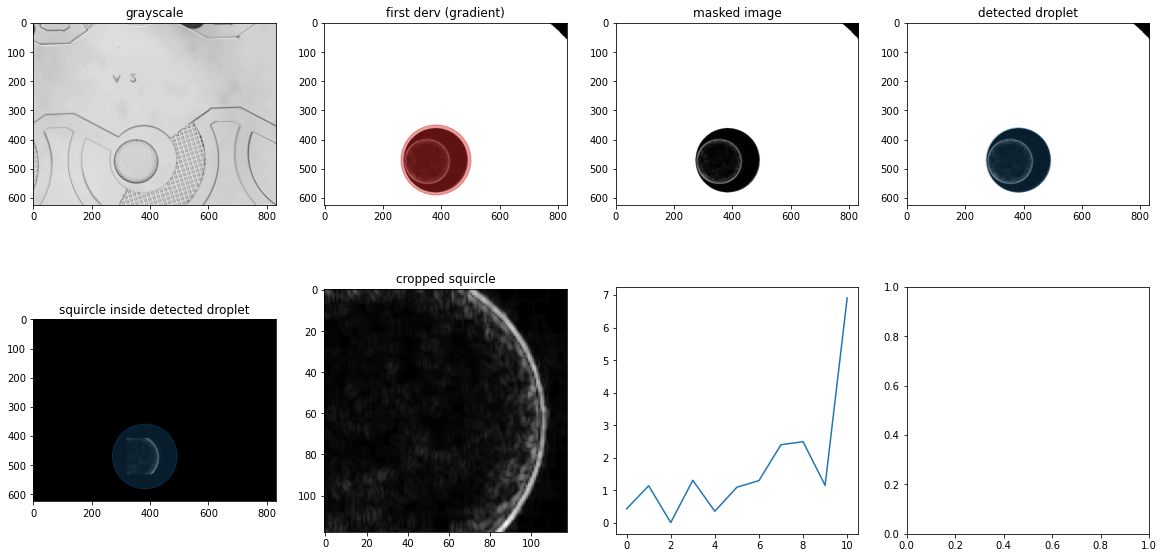

In [10]:
c = 3
w = 1
t = 12


image = time_resolution[t][c][w]['gray'].copy()
img  = time_resolution[t][c][w]['img'].copy() # masked img
grad  = time_resolution[t][c][w]['grad2'].copy()
xd = time_resolution[t][c][w]['droplet data'][0,0]
yd = time_resolution[t][c][w]['droplet data'][0,1]
rd = time_resolution[t][c][w]['droplet data'][0,2]
xw = time_resolution[t][c][w]['x']
yw = time_resolution[t][c][w]['y']
rw = time_resolution[t][c][w]['r']


fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

axs[0, 0].imshow(image, cmap="gray")
axs[0,0 ].set_title("grayscale")

axs[0, 1].imshow(grad, cmap="gray")
axs[0, 1].set_title("first derv (gradient)")
circle = plt.Circle((xw, yw), rw, color='tab:red', alpha=0.45)
axs[0, 1].add_patch(circle)

axs[0, 2].imshow(img, cmap="gray")
axs[0, 2].set_title("masked image")

axs[0, 3].imshow(img, cmap="gray")
axs[0, 3].set_title("detected droplet")
circle = plt.Circle((xd, yd), rd, color='tab:blue', alpha=0.25)
axs[0, 3].add_patch(circle)

axs[1, 0].imshow(time_resolution[t][c][w]['squ'], cmap="gray")
axs[1, 0].set_title("squircle inside detected droplet")
circle = plt.Circle((xd, yd), rd, color='tab:blue', alpha=0.25)
axs[1, 0].add_patch(circle)

axs[1, 1].imshow(time_resolution[t][c][w]['cro squ'], cmap="gray")
axs[1, 1].set_title("cropped squircle")

axs[1, 2].plot(np.arange(len(time_resolution[0][c][w]['mean list'])), time_resolution[0][c][w]['mean list'])
axs[1, 2].scatter(t, time_resolution[0][c][w]['mean list'][t], color='red')

blurrr = cv2.dilate(time_resolution[t][c][w]['cro squ'], (5,5))
print(blurrr.shape[0]*blurrr.shape[0] - np.count_nonzero(blurrr))

print("meanlist", time_resolution[0][c][w]['mean list'], "; mean:", np.mean(time_resolution[0][c][w]['mean list']))
print("perc. difference @ t:", int((time_resolution[0][c][w]['mean list'][-1]/np.mean(time_resolution[0][c][w]['mean list'])*100-100)))
print("Areas:", time_resolution[0][c][w]['areas'])
print("starting conc:", starting_concentrations[c])
print("LLPS conc:", time_resolution[0][c][w]['LLPS conc'])

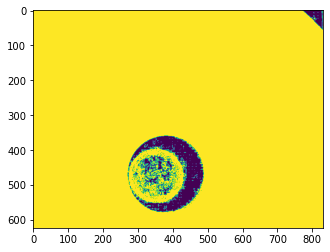

In [19]:
def first_derivative(gray_image):
    scale = 1
    delta = 0
    ddepth = cv2.CV_16S

    grad_x = cv2.Sobel(gray_image, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(gray_image, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)

    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

    return grad
import cv2
grad = first_derivative(img)
ret, imggg = cv2.threshold(img, 5, 255, cv2.THRESH_BINARY)
plt.imshow(imggg)

In [11]:
img[500]

array([255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 25

In [ ]:
def find_circle(img: np.ndarray, diameter: int, n: float, m: float):
    dp = 1.4
    minDist = 450
    param1 = 50
    param2 = 40
    min_r_chamber = int((diameter / 2) * n)
    max_r_chamber = int((diameter / 2) * m)

    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT,
                               dp=dp, minDist=minDist, param1=param1, param2=param2,
                               minRadius=min_r_chamber, maxRadius=max_r_chamber)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        circles_for_dict = circles
        # x, y, radius = circles[0][0]
        x = circles_for_dict[0, 0, 0]
        y = circles_for_dict[0, 0, 1]
        r = circles_for_dict[0, 0, 2]
    else:
        x = 0
        y = 0
        r = 0

    return x, y, r


def mask_img_circle(image, x, y, r, t):
    f = 0.95
    d = 250
    img_c = cv2.circle(image, (x, y), int(r * f + d), color=(255, 255, 255), thickness=d * 2)

    return img_c

############################################

#img_c = mask_img_circle(image, xw, yw, rw, t)

imgg = grad.copy()
n = 0
m = 0.9
x, y, r = find_circle(imgg, diameter, n, m)

fig, axs = plt.subplots(nrows=2, figsize=(20, 10))

axs[0].imshow(imgg, cmap='gray')
circle = plt.Circle((x, y), r, color='tab:red', alpha=0.25)
axs[0].add_patch(circle)

In [ ]:
def image_manipulation(masked_img):
    img_circle = masked_img
    blur = cv2.blur(img_circle.copy(), (2, 2))
    thresh_adpt = cv2.adaptiveThreshold(blur.copy(), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    morph = cv2.morphologyEx(thresh_adpt.copy(), cv2.MORPH_CLOSE, (8, 8), iterations=1)
    # morph = cv2.erode(thresh_adpt, (5, 5), iterations=5)
    img = cv2.dilate(morph.copy(), (2, 2), iterations=1)

    return img

def find_multiple_droplets(threshold_img, xw, yw, rw):
    # detects if there are multiple droplets in a well
    # also kicks out too small droplets
    n = 0
    f = 0.65
    threshold = 650

    eroded = cv2.dilate(threshold_img.copy(), (20, 20), iterations=4)
    crop = eroded[int(yw - rw * f):int(yw + rw * f), int(xw - rw * f):int(xw + rw * f)]

    for x, y in np.ndindex(crop.shape):
        if crop[x, y] == 0:
            n += 1

    if n > threshold:
        multidroplet = True
        logger.warning("Multiple droplet was triggered!")
    else:
        multidroplet = False
    print("n:", n)

    return multidroplet


manip_img = image_manipulation(img.copy())
manipp_img = cv2.dilate(manip_img, (5,5))
boool = find_multiple_droplets(manipp_img, xw, yw, rw)
print(boool)

f = 0.65
eroded = cv2.dilate(manip_img.copy(), (20, 20), iterations=4)
crop = eroded[int(yw - rw * f):int(yw + rw * f), int(xw - rw * f):int(xw + rw * f)]

plt.imshow(crop, cmap='gray')
print(np.count_nonzero(crop))
print(crop.shape)

## quality control

## Plot the data

In [ ]:
### figure setup ###


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,8), sharex=False, sharey=False)

# set labels
ax1.set_xlabel(f"{name_sol2} [{unit_sol2}]")
ax1.set_ylabel(f"{name_sol1} [{unit_sol1}]")
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

ax2.set_xlabel(ax1.get_xlabel())
ax2.xaxis.label.set_size(ax1.xaxis.label.get_size())
ax2.set_ylabel(ax1.get_ylabel())
ax2.yaxis.label.set_size(ax1.yaxis.label.get_size())

# set limits 
xlim = int(initial_conc_sol2 * 6)
ylim = int(initial_conc_sol1 * 6)
ax1.set_xlim(0, xlim)
ax1.set_ylim(0, ylim)
ax2.set_xlim(0, xlim)
ax2.set_ylim(0, ylim)

# set titles
ax1.set_title('individual wells', fontsize=25)
ax2.set_title('means', fontsize= 25)

# set ticks
ax1.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax1.tick_params(axis='y', which='minor', right=True)
ax1.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax1.tick_params(axis='x', which='minor', bottom=True, top=True)
ax1.minorticks_on()
ax1.xaxis.set_major_locator(MultipleLocator(20))
ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
ax1.yaxis.set_major_locator(MultipleLocator(100))
ax1.yaxis.set_minor_locator(AutoMinorLocator(20))
ax1.xaxis.set_tick_params(which='both', width=2)
ax1.yaxis.set_tick_params(which='both', width=2)


ax2.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax2.tick_params(axis='y', which='minor', right=True)
ax2.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax2.tick_params(axis='x', which='minor', bottom=True, top=True)
ax2.minorticks_on()
ax2.xaxis.set_major_locator(MultipleLocator(20))
ax2.xaxis.set_minor_locator(AutoMinorLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(100))
ax2.yaxis.set_minor_locator(AutoMinorLocator(20))
ax2.xaxis.set_tick_params(which='both', width=2)
ax2.yaxis.set_tick_params(which='both', width=2)


# plot starting concentrations and the data
well_nr = 0

for conc_nr in range (number_of_diff_conc):
    for n_horizontals_per_conc in range(2):
        for n_wells_per_horizontal in range(n_wells):
            if time_resolution[0][conc_nr][well_nr]['areas'][0, 1] != 0:
            
                if conc_nr == 0:
                    color = "blue"
                if conc_nr == 1:
                    color = "orange"
                if conc_nr == 2:
                    color = "gray"
                if conc_nr == 3:
                    color = "yellow"
                if conc_nr == 4:
                    color = "green"

                ax1.scatter(starting_concentrations[conc_nr,1], starting_concentrations[conc_nr,0], s=60, c=color, marker="s", edgecolors="black")
                ax1.scatter(time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1],time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0],
                            s=60, color=color, marker="o", edgecolors="black")
                
            well_nr += 1
    well_nr = 0
well_nr = 0


# calculate and plot mean
mean_sol1 = []
mean_sol1 = [0] * 5
mean_sol2 = []
mean_sol2 = [0] * 5
n_llps_wells = []
n_llps_wells = [0] * 5

for conc_nr in range (number_of_diff_conc):
    for n_horizontals_per_conc in range(2):
        for n_wells_per_horizontal in range(n_wells):
            if time_resolution[0][conc_nr][well_nr]['areas'][0, 1] != 0:           
                # calculate mean
                mean_sol1[conc_nr] = mean_sol1[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0]
                print(conc_nr, well_nr, time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0])
                mean_sol2[conc_nr] = mean_sol2[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1]
                n_llps_wells[conc_nr] += 1
                
            well_nr += 1
    well_nr = 0
well_nr = 0

print("post post", mean_sol1[1])

for conc_nr in range(number_of_diff_conc):
    if conc_nr == 0:
        color = "blue"
    if conc_nr == 1:
        color = "orange"
    if conc_nr == 2:
        color = "gray"
    if conc_nr == 3:
        color = "yellow"
    if conc_nr == 4:
        color = "green"
    if n_llps_wells[conc_nr] > 0:
        mean_sol1[conc_nr] = mean_sol1[conc_nr]/n_llps_wells[conc_nr]
        mean_sol2[conc_nr] = mean_sol2[conc_nr]/n_llps_wells[conc_nr]
        m = mean_sol1[conc_nr]/mean_sol2[conc_nr]
        
    ax2.plot([0, mean_sol2[conc_nr],xlim], [0, mean_sol1[conc_nr], m*xlim], color=color, linestyle='dashed', alpha=0.50)
    ax2.scatter(starting_concentrations[conc_nr,1], starting_concentrations[conc_nr,0], s=60, c=color, marker="s", edgecolors="black")

    ax2.scatter(mean_sol2[conc_nr],mean_sol1[conc_nr], s=60, color=color,
                           marker="o", edgecolors="black")
 